In [53]:
from plottr.data.datadict_storage import datadict_from_hdf5
from plottr.data.datadict_storage import DataDict, DDH5Writer
from plottr.data.datadict_storage import search_datadict
import numpy as np
import matplotlib.pyplot as plt
import os
from pprint import pprint
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import copy
import itertools
# import scqubits as scq
import csv
from sklearn.decomposition import PCA
from scipy.signal import find_peaks
from lmfit import Model

from scipy.optimize import curve_fit


This notebook is a short revision exercise of an essential methods of doing photon tomography, which is the reconstruction of the density matrix.

Fido function

In [54]:

basedir = r"D:/Redza/Logs"
show_plots =True
#Fido function to obtain monitr files
def Fido(datetime, name):          #Fido gets your raw _data for you!
    foldername, datadict = search_datadict(basedir, datetime, name=name , newest = True, only_complete=False)
    print(foldername)
    print(datadict)
    return foldername, datadict

Test: Constructing a density matrix

In [55]:
# tomoFolder, tomoDict = Fido("2025-09-24T204341", "tomography_allDensityMatrices")
# photon_p = tomoDict['p_0']['values']
# photon_q =  tomoDict['q_0']['values']
# vacuum_p = tomoDict['p_0_vacuum']['values']
# vacuum_q = tomoDict['q_0_vacuum']['values']

tomoFolder, tomoDict = Fido("2025-09-24T204341", "tomography_allDensityMatrices")
photon_p = tomoDict['p_0']['values'][0]
photon_q =  tomoDict['q_0']['values'][0]
vacuum_p = tomoDict['p_0_vacuum']['values'][0]
vacuum_q = tomoDict['q_0_vacuum']['values'][0]

2025-09-24T204341_b7ffa91e-tomography_allDensityMatrices
p_0: (1, 10000)
  ⌙ shot: (1, 10000)
p_0_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
p_0minus1: (1, 10000)
  ⌙ shot: (1, 10000)
p_0minus1_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
p_0minusi: (1, 10000)
  ⌙ shot: (1, 10000)
p_0minusi_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
p_0plus1: (1, 10000)
  ⌙ shot: (1, 10000)
p_0plus1_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
p_0plusi: (1, 10000)
  ⌙ shot: (1, 10000)
p_0plusi_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
p_1: (1, 10000)
  ⌙ shot: (1, 10000)
p_1_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
q_0: (1, 10000)
  ⌙ shot: (1, 10000)
q_0_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
q_0minus1: (1, 10000)
  ⌙ shot: (1, 10000)
q_0minus1_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
q_0minusi: (1, 10000)
  ⌙ shot: (1, 10000)
q_0minusi_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
q_0plus1: (1, 10000)
  ⌙ shot: (1, 10000)
q_0plus1_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
q_0plusi: (1, 10000)
  ⌙ shot: (1, 10000)
q_0plusi_vacu

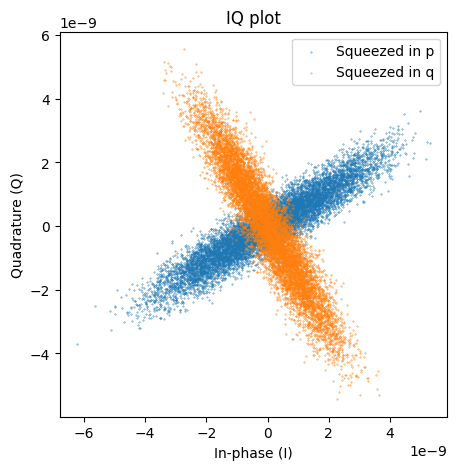

In [56]:
# plotting IQ plane to verify
# plot_path = os.path.join(data_path + '\Images', measurement_name)
squeezed_p = photon_p
squeezed_q = photon_q

plt.figure(figsize = [5,5])
plt.scatter(squeezed_p.real, squeezed_p.imag, s = 0.1,label='Squeezed in p')
plt.scatter(squeezed_q.real, squeezed_q.imag, s = 0.1,label='Squeezed in q')
# plt.xlim([-1e-9,1e-9])
# plt.ylim([-1e-9,1e-9])
plt.xlabel("In-phase (I)")
plt.ylabel("Quadrature (Q)")
plt.legend()
plt.title('IQ plot')
plt.show()

Rotating the plotted points to align with the IQ axes:

0.5331826923492737


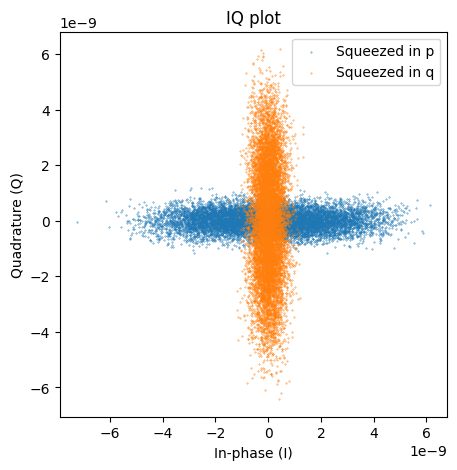

In [57]:
#PCA function to determine alignment axes
def pca_quadrature(a):
    data_IQ = np.array([a.real, a.imag]).T
    pca = PCA(n_components=2)
    pca.fit(data_IQ)
    # print(pca.components_.T)
    eigenvec = pca.components_.T[:, 0]
    theta = np.arctan(eigenvec[1]/eigenvec[0])
    return theta

phase = pca_quadrature(squeezed_p)
print(phase)

squeezed_p = squeezed_p * np.exp(-1j * phase)
squeezed_q = squeezed_q * np.exp(-1j * phase)
# plotting IQ plane to verify
# plot_path = os.path.join(data_path + '\Images', measurement_name)

plt.figure(figsize = [5,5])
plt.scatter(squeezed_p.real, squeezed_p.imag, s = 0.1,label='Squeezed in p')
plt.scatter(squeezed_q.real, squeezed_q.imag, s = 0.1,label='Squeezed in q')
# plt.xlim([-1e-9,1e-9])
# plt.ylim([-1e-9,1e-9])
plt.xlabel("In-phase (I)")
plt.ylabel("Quadrature (Q)")
plt.legend()
plt.title('IQ plot')
plt.show()

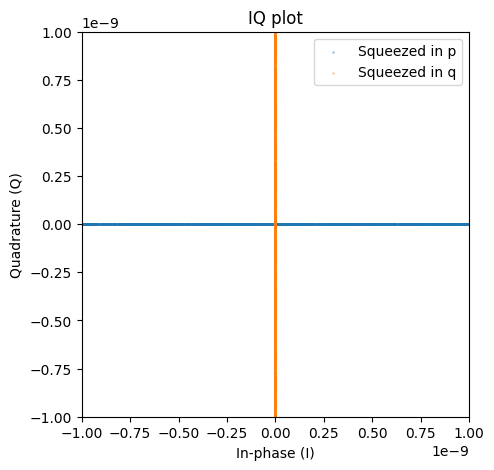

In [58]:
#The expectation values are calculated by projecting q results down into Im, and p results down into Re
squeezed_p = np.real(squeezed_p)
squeezed_q = np.imag(squeezed_q)
squeezed_q_forPlot = squeezed_q * 1j

plt.figure(figsize = [5,5])
plt.scatter(squeezed_p.real, squeezed_p.imag, s = 0.1,label='Squeezed in p')
plt.scatter(squeezed_q_forPlot.real, squeezed_q_forPlot.imag, s = 0.1,label='Squeezed in q')
plt.xlim([-1e-9,1e-9])
plt.ylim([-1e-9,1e-9])
plt.xlabel("In-phase (I)")
plt.ylabel("Quadrature (Q)")
plt.legend()
plt.title('IQ plot')
plt.show()

In [59]:
#calculating quadrature expectation values

p_bar = np.mean(squeezed_p)
q_bar = np.mean(squeezed_q)

p2_bar = np.mean([p**2 for p in squeezed_p])
q2_bar = np.mean([q**2 for q in squeezed_q])

#calculating Pauli matrix expectation values
X_bar = np.sqrt(2) * q_bar
Y_bar = np.sqrt(2) * p_bar
Z_bar = 2 - q2_bar - p2_bar

print(X_bar)
print(Y_bar)
print(Z_bar)

#the pauli matrices
pauli_i = np.array([[1,0],[0,1]])
pauli_x =np.array([[0,1],[1,0]])
pauli_y =np.array([[0,-1j],[1j,0]])
pauli_z = np.array([[1,0],[0,-1]])

-4.569514905299658e-12
4.4114000002655415e-12
2.0


This actually shows that the scaling is not done properly for the data. Scaling requires us to normalize the points of the individual measurements using data from the vacuum. This is according to the following formula.

# $S_{scaled} = \frac{S_{experiment} - \mu}{\sqrt{2} \sigma}$

where $\mu$ is the mean of the vacuum measurement, and $\sigma$ is the standard deviation of the vacuum measurement.

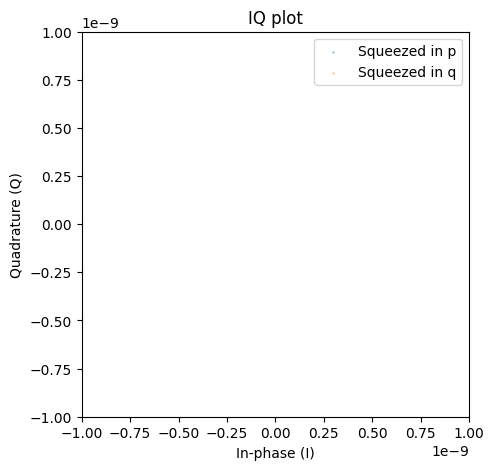

In [60]:
# Replotting with normalization

photon_p *=  np.exp(-1j * phase)
photon_q *=  np.exp(-1j * phase)
vacuum_p *=  np.exp(-1j * phase)
vacuum_q *=  np.exp(-1j * phase)

projected_p = np.real(squeezed_p)
projected_q = np.imag(squeezed_q)
projected_p_vac = np.real(vacuum_p)
projected_q_vac = np.imag(vacuum_q)

normalized_p = (projected_p - np.mean(projected_p_vac))/(projected_p_vac.std() * np.sqrt(2))
normalized_q = (projected_q - np.mean(projected_q_vac))/(projected_q_vac.std() * np.sqrt(2))
normalized_q_forPlot = normalized_q * 1j

plt.figure(figsize = [5,5])
plt.scatter(normalized_p.real, normalized_p.imag, s = 0.1,label='Squeezed in p')
plt.scatter(normalized_q_forPlot.real, normalized_q_forPlot.imag, s = 0.1,label='Squeezed in q')
plt.xlim([-1e-9,1e-9])
plt.ylim([-1e-9,1e-9])
plt.xlabel("In-phase (I)")
plt.ylabel("Quadrature (Q)")
plt.legend()
plt.title('IQ plot')
plt.show()

And now, with these scaled measurements, we may reattempt the calculation of the density matrix.

In [61]:
#calculating quadrature expectation values

p_bar = np.mean(normalized_p)
q_bar = np.mean(normalized_q)

p2_bar = np.mean([p**2 for p in normalized_p])
q2_bar = np.mean([q**2 for q in normalized_q])

#calculating Pauli matrix expectation values
X_bar = np.sqrt(2) * q_bar
Y_bar = np.sqrt(2) * p_bar
Z_bar = 2 - q2_bar - p2_bar

print(X_bar)
print(Y_bar)
print(Z_bar)

#the pauli matrices
pauli_i = np.array([[1,0],[0,1]])
pauli_x =np.array([[0,1],[1,0]])
pauli_y =np.array([[0,-1j],[1j,0]])
pauli_z = np.array([[1,0],[0,-1]])

density_matrix =0.5 * (pauli_i + X_bar * pauli_x + Y_bar * pauli_y + Z_bar * pauli_z)

print(density_matrix)

0.003337668586496104
0.015357584322383764
1.4707741823970746
[[ 1.23538709+0.j          0.00166883-0.00767879j]
 [ 0.00166883+0.00767879j -0.23538709+0.j        ]]


Even with this, the obtained density matrix is not ideal. We need to also account for the measurement efficiency, which is separately calculated. 